<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [2]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


<h3>Get the data and copy it to S3</h3>

In [3]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://mysolnbucket/ --recursive

<h3>Set up parameters, estimator, and tuner</h3>

In [4]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [5]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [6]:
os.environ['SM_CHANNEL_TRAINING']='s3://mysolnbucket/'
os.environ['SM_MODEL_DIR']='s3://mysolnbucket/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://mysolnbucket/output/'
tuner.fit({"training": "s3://mysolnbucket/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [36]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-240203-2105')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
0      "256"       0.056615  pytorch-training-240203-2105-003-27ca1bc9   
2       "64"       0.012513  pytorch-training-240203-2105-001-29945697   
1      "512"       0.011144  pytorch-training-240203-2105-002-9cd59682   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
0         Completed               1019.0 2024-02-03 21:33:14+00:00   
2         Completed                279.0 2024-02-03 21:06:44+00:00   
1            Failed                  NaN 2024-02-03 21:30:24+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
0 2024-02-03 21:52:14+00:00                      1140.0  
2 2024-02-03 21:26:55+00:00                      1211.0  
1 2024-02-03 21:32:51+00:00                       147.0

## Imp: If kernel dies, how to continue from a completed training job

In [37]:
#BetterTrainingJobName='pytorch-training-210623-2156-001-fdd5e081'
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
#my_estimator.hyperparameters()
#best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [38]:
best_estimator=tuner.best_estimator()


2024-02-03 21:30:23 Starting - Preparing the instances for training
2024-02-03 21:30:23 Downloading - Downloading the training image
2024-02-03 21:30:23 Training - Training image download completed. Training in progress.
2024-02-03 21:30:23 Uploading - Uploading generated training model
2024-02-03 21:30:23 Completed - Resource reused by training job: pytorch-training-240203-2105-002-9cd59682


In [39]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"64"',
 'learning_rate': '0.012513206139037355',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2024-02-03-21-05-16-063"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-225850419240/pytorch_dog_hpo-2024-02-03-21-05-16-063/source/sourcedir.tar.gz"'}

In [40]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 64, 'learning_rate': '0.012513206139037355'}

In [41]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [42]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


<h2>Creating an Estimator</h2>

In [43]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [45]:
estimator.fit({"training": "s3://mysolnbucket/"}, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2024-02-03-22-38-11-660


<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [90]:
###in this cell, create and fit an estimator using multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=5,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config)


In [91]:
%%capture
estimator.fit({"training": "s3://mysolnbucket/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2024-02-03-23-41-32-247


<h2>Deployment</h2>

In [92]:
model_location=estimator.model_data


In [93]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [94]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [95]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [96]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-225850419240/dog-pytorch-2024-02-03-23-41-32-247/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-225850419240/pytorch-inference-2024-02-04-00-03-53-656/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-02-04-00-04-05-337
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-02-04-00-04-06-093
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-02-04-00-04-06-093


-----!

In [97]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

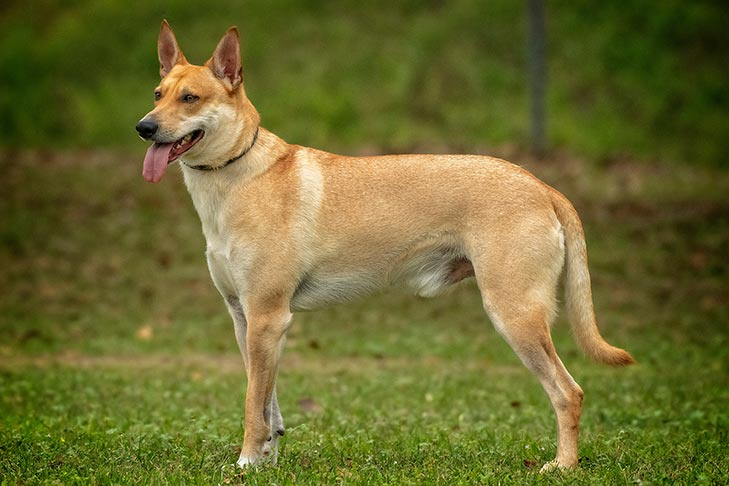

In [98]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [99]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [100]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [101]:
type(response2[0][0])

float

In [102]:
response2[0]

[-4.7603302001953125,
 -9.347135543823242,
 -3.103496789932251,
 3.9978339672088623,
 2.376417636871338,
 2.4516522884368896,
 -3.0252161026000977,
 -0.04143361747264862,
 -5.755343914031982,
 1.8749241828918457,
 3.4796314239501953,
 1.5231249332427979,
 -2.610837936401367,
 3.596266746520996,
 -8.696382522583008,
 -3.4591751098632812,
 -4.7855329513549805,
 3.215360403060913,
 -10.860492706298828,
 3.7884984016418457,
 2.984393835067749,
 3.196214199066162,
 0.7586737871170044,
 -7.796797275543213,
 -3.765272378921509,
 -11.843153953552246,
 -4.7777509689331055,
 -2.63692569732666,
 2.536834716796875,
 -1.7651348114013672,
 -5.127273082733154,
 1.7506623268127441,
 -9.091468811035156,
 -4.153798580169678,
 -3.889939785003662,
 -8.115314483642578,
 -7.656178951263428,
 -3.288999319076538,
 -1.432348370552063,
 -5.1768951416015625,
 -3.054049015045166,
 -2.6342406272888184,
 3.029165267944336,
 -3.9904842376708984,
 3.950164556503296,
 -4.892093181610107,
 -1.0851519107818604,
 3.00718

In [103]:
import torch
import numpy as np
np.argmax(response, 1)

array([3])